# 注意事项
0. 似乎原文中本段笔记并不完全,导致许多未知的问题,建议跳过这一个笔记,对接下来的任务没有影响.在下一个笔记本下载网上预处理好的数据.

1. 这个笔记本用于数据预处理,与流匹配训练过程无关,在本地运行.其中使用的环境与流匹配环境不同,需要新建一个环境,否则会出现以下pandas版本冲突的问题
`torchcfm 1.0.7 requires pandas>=2.2.2, but you have pandas 2.0.3 which is incompatible.`

2. 环境:
python==3.9

pandas==1.5.3

numpy==1.23.5

matplotlib

jupyterlab

以下库不一定需要:

scanpy

phate

igraph

leidenalg

3. 数据下载
在网页<https://data.mendeley.com/datasets/v6n743h5ng/>中下载,把`scRNAseq`文件解压到`../data/`目录下.原文提到代码可以自动下载,但我不能成功运行,所以去网上手动下载了.

# 数据加载与预处理
在本教程中，我们将演示如何使用单细胞RNA测序（scRNA-seq）技术处理包含31,000个细胞的27天胚胎体（EB）分化时间序列数据。

我们将介绍以下步骤：

1. 加载10X数据
2. 过滤
3. 归一化
4. 转换

## 0. 介绍 `scprep`

`scprep` 是一款面向 Python 数据科学家的轻量级单细胞 RNA 测序（scRNA-seq）工具包。

大多数单细胞 RNA 测序工具包基于 R 语言开发（其中最知名的是 [Seurat](https://satijalab.org/seurat/)），但我们（以及大部分机器学习/数据科学研究者）的工具开发工作基于 Python 语言。目前，[Scanpy](https://icb-scanpy.readthedocs-hosted.com/en/stable/) 是 Python 生态中最常用的单细胞 RNA 测序分析工具包。然而，Scanpy 采用高度结构化的数据表征框架，与 Python 数据科学领域的大部分主流工具（如 [pandas](https://pandas.pydata.org/)、[SciPy](https://www.scipy.org/) 和 [scikit-learn](https://scikit-learn.org/stable/)）不兼容。

为适配更广泛的 Python 数据分析生态用户，我们开发了 `scprep`（即 **s**ingle **c**ell **prep**aration，单细胞数据预处理）。借助 `scprep`，研究者能更便捷地将 pandas/SciPy/scikit-learn 生态用于单细胞 RNA 测序分析。`scprep` 的核心功能由一系列辅助函数构成，可完成单细胞数据的常见处理任务，例如加载计数矩阵、根据文库大小筛选与标准化细胞，以及计算常用统计量。`scprep` 的关键优势在于：数据可存储为 Pandas 数据框（DataFrame）、NumPy 数组、SciPy 稀疏矩阵等格式，无论你选择与哪些工具对接，均能实现“即插即用”。

如需了解更多关于 `scprep` 的信息，可查阅官方文档：https://scprep.readthedocs.io/。

## 1. 安装工具

要运行本笔记本，你需要下载几个软件包。遗憾的是，受 Google Colab 平台限制，这些安装的软件包不会被保存。如果需要解决此问题，你可以参考以下链接中的方法：https://stackoverflow.com/questions/52582858/saving-pip-installs-in-google-colab

目前，只需点击代码单元格，然后按下 `Shift` + `Enter` 键，运行下面这行代码即可。

In [1]:
!pip install scprep tasklogger

### 人类类胚体分化的时间进程
低传代的 H1 人胚胎干细胞（hESCs）在添加了成纤维细胞生长因子 2（FGF2）的 DMEM/F12-N2B27 培养基中，于基质胶（Matrigel）包被的培养皿上培养。为形成类胚体（EB），细胞经分散酶（Dispase）处理后解离成小细胞团，接种到非贴壁培养板中，培养基中添加了经类胚体分化预筛选的 20% 胎牛血清（FBS）。在 27 天的分化时间进程中，每 3 天收集一次样本，同时还纳入了未分化的人胚胎干细胞样本（图 S7D）。通过实时定量聚合酶链反应（qPCR）验证了这些类胚体培养物中关键胚层标志物的诱导表达（数据未展示）。用于单细胞分析时，类胚体培养物先解离，再通过荧光激活细胞分选（FACS）去除双细胞和死细胞，随后使用 10x Genomics 仪器处理以构建 cDNA 文库，进而进行测序。小规模测序结果显示，我们已成功收集到约 31000 个细胞的数据，这些细胞在整个时间进程中分布均匀。

### 从Mendeley数据集下载数据
类胚体（EB）数据集以`scRNAseq.zip`的形式在Mendeley数据集平台公开可用，访问地址为<https://data.mendeley.com/datasets/v6n743h5ng/>。

在scRNAseq文件夹内包含5个子目录，每个子目录下均有3个文件：`barcodes.tsv`、`genes.tsv`和`matrix.mtx`。若需了解CellRanger软件如何生成这些文件，可查阅《基因-条形码矩阵文档》（[Gene-Barcode Matrices Documentation](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/output/matrices)）。

目录结构如下：
```
download_path
└── scRNAseq
    ├── scRNAseq.zip
    ├── T0_1A
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    ├── T2_3B
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    ├── T4_5C
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    ├── T6_7D
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    └── T8_9E
        ├── barcodes.tsv
        ├── genes.tsv
        └── matrix.mtx
```

若你已下载相关文件，请将下方的`download_path`设置为文件保存目录；若未下载，以下代码将为你自动下载数据。请注意，该下载文件大小为746MB，你需确保有足够的磁盘空间用于下载。

**请注意**：若你需分析由新版本`cellranger`（10X Genomics公司提供的一款软件，可将原始fastq文件转化为计数矩阵）生成的数据，每个样本会生成3个文件：`barcodes.tsv.gz`、`features.tsv.gz`和`matrix.mtx.gz`。使用`scprep`加载这些文件的流程与旧版本完全一致。

### 使用`scprep`将数据导入Pandas数据框（DataFrame）

我们使用一款名为`scprep`的工具包来加载和处理单细胞数据。其中`load_10X`函数可自动将10X单细胞RNA测序（scRNAseq）数据集（及其他相关数据集）加载为Pandas数据框（DataFrame）。数据框是Python中极为实用的数据分析工具，若需深入了解其用法，可查阅《Pandas文档与教程》（[check out the Pandas Documentation and Tutorials](https://pandas.pydata.org/pandas-docs/stable/)）。

接下来，我们将加载数据并构建一个单一矩阵，用于后续的数据预处理、可视化及分析工作。

### 2.1 标准导入（模块）

在几乎所有（代码）会话的开头，我们都会导入这几个软件包。

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scprep

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

### 2.2 使用`scprep.io.load_10X`将所有三个矩阵导入DataFrame

#### 理解稀疏数据与稠密数据的区别
默认情况下，`scprep.io.load_10X`会使用带稀疏列的Pandas DataFrame加载单细胞RNA测序（scRNA-seq）数据[（参见Pandas文档）](https://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html)，以实现内存使用效率最大化。但这种方式会比加载稠密矩阵更慢。我们来看看加载第一个时间点的数据所需的时间，以及稠密数据和稀疏数据分别占用多少内存。我们将使用`tasklogger`来衡量每个加载步骤所需的时间。

In [4]:
import os
import pickle

import tasklogger

# 将下载路径改为本地路径
# download_path = "/home/mila/a/alexander.tong/scratch/time_series/"
download_path = "../data/"


# load data in dense format
with tasklogger.log_task("dense"):
    data_time1 = scprep.io.load_10X(
        os.path.join(download_path, "scRNAseq", "T0_1A"), sparse=False, gene_labels="both"
    )

# measure the size of the matrix with pickle
print("Size: {:.1f}MB".format(len(pickle.dumps(data_time1)) / 1024**2))

# load data in sparse format
with tasklogger.log_task("sparse"):
    data_time1 = scprep.io.load_10X(
        os.path.join(download_path, "scRNAseq", "T0_1A"), sparse=True, gene_labels="both"
    )

# measure the size of the matrix with pickle
print("Size: {:.1f}MB".format(len(pickle.dumps(data_time1)) / 1024**2))

Calculating dense...
Calculated dense in 1.51 seconds.
Size: 1196.1MB
Calculating sparse...
Calculated sparse in 6.05 seconds.
Size: 114.9MB


因此，只需在计算时间上付出少量代价，我们就能节省大量内存。如果内存有限（例如在Google Colaboratory上），建议使用稀疏格式。

你可能还注意到，我们收到了一条警告（上方红色提示），提示基因符号（gene symbols）不唯一。这对稠密数据不会造成问题，但对稀疏数据会产生影响。我们可以通过指定`gene_labels='both'`，将列名设置为`基因符号 (Ensembl ID)`的格式——这样既保留了基因符号的人类可读性，又具备了Ensembl ID的唯一性。

#### 理解数据矩阵

我们的矩阵有多大？可以用 `data.shape` 来查看。

In [5]:
data_time1.shape

(4649, 33694)

我们的数据矩阵包含4700个细胞（行）和33600个基因（列）。每一行和每一列都有对应的名称。  
其中，**列**代表基因（即数据的“特征”），通过 `data.columns` 可以将这些列名以列表形式查看。

In [6]:
data_time1.columns

Index(['RP11-34P13.3 (ENSG00000243485)', 'FAM138A (ENSG00000237613)',
       'OR4F5 (ENSG00000186092)', 'RP11-34P13.7 (ENSG00000238009)',
       'RP11-34P13.8 (ENSG00000239945)', 'RP11-34P13.14 (ENSG00000239906)',
       'RP11-34P13.9 (ENSG00000241599)', 'FO538757.3 (ENSG00000279928)',
       'FO538757.2 (ENSG00000279457)', 'AP006222.2 (ENSG00000228463)',
       ...
       'AC007325.2 (ENSG00000277196)', 'BX072566.1 (ENSG00000277630)',
       'AL354822.1 (ENSG00000278384)', 'AC023491.2 (ENSG00000278633)',
       'AC004556.1 (ENSG00000276345)', 'AC233755.2 (ENSG00000277856)',
       'AC233755.1 (ENSG00000275063)', 'AC240274.1 (ENSG00000271254)',
       'AC213203.1 (ENSG00000277475)', 'FAM231B (ENSG00000268674)'],
      dtype='object', length=33694)

**行**代表细胞（即数据的“观测对象”），通过 `data.index` 可以将这些行名以列表形式查看。  

（注：在单细胞RNA测序数据语境中，“observations”此处特指对单个细胞的观测，因此行索引通常对应细胞的唯一标识，如细胞条形码；而前文的“features”则对应基因，是描述细胞特征的维度。）

In [7]:
data_time1.index

Index(['AAACATACCAGAGG-1', 'AAACATTGAAAGCA-1', 'AAACATTGAAGTGA-1',
       'AAACATTGGAGGTG-1', 'AAACATTGGTTTCT-1', 'AAACCGTGCAGAAA-1',
       'AAACCGTGGAAGGC-1', 'AAACCGTGGCTACA-1', 'AAACGCACCGGTAT-1',
       'AAACGCACCTATTC-1',
       ...
       'TTTCGAACCCTCGT-1', 'TTTCGAACGTCCTC-1', 'TTTCTACTATCGAC-1',
       'TTTGACTGAACGTC-1', 'TTTGACTGCTCAAG-1', 'TTTGACTGCTTCTA-1',
       'TTTGACTGTGCCCT-1', 'TTTGCATGAGGTCT-1', 'TTTGCATGGGCGAA-1',
       'TTTGCATGTGACAC-1'],
      dtype='object', name=0, length=4649)

需要注意的是，有些工具的预期格式与此相反：它们希望基因位于行、细胞位于列。这种格式是从 bulk RNA-seq（批量RNA测序）延续下来的——在批量测序中，生物学重复样本数量较少（可作为“特征”），而基因数量较多（可作为“观测对象”），因此这种格式具有合理性；但如今在单细胞测序中，细胞数量可能与基因数量相当，甚至更多，此时将细胞作为“观测对象”（行）会更合理。在使用新工具时，请务必留意这种格式差异。

最后，我们可以查看矩阵的实际数据：直接输入矩阵名称即可查看完整矩阵，或使用 `.head()` 函数查看前几行数据。

In [9]:
data_time1.head()

,RP11-34P13.3 (ENSG00000243485),FAM138A (ENSG00000237613),OR4F5 (ENSG00000186092),RP11-34P13.7 (ENSG00000238009),RP11-34P13.8 (ENSG00000239945),RP11-34P13.14 (ENSG00000239906),RP11-34P13.9 (ENSG00000241599),FO538757.3 (ENSG00000279928),FO538757.2 (ENSG00000279457),AP006222.2 (ENSG00000228463),...,AC007325.2 (ENSG00000277196),BX072566.1 (ENSG00000277630),AL354822.1 (ENSG00000278384),AC023491.2 (ENSG00000278633),AC004556.1 (ENSG00000276345),AC233755.2 (ENSG00000277856),AC233755.1 (ENSG00000275063),AC240274.1 (ENSG00000271254),AC213203.1 (ENSG00000277475),FAM231B (ENSG00000268674)
0,,,,,,,,,,,,,,,,,,,,,
AAACATACCAGAGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGAAAGCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGAAGTGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGGAGGTG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGGTTTCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 加载完整数据集

既然我们已经知道如何加载数据，接下来就加载每个样本的数据矩阵（这可能需要几分钟时间）。注意，[`scprep.io`](https://scprep.readthedocs.io/en/stable/reference.html#module-scprep.io) 提供了一系列不同的输入函数：还支持 csv、tsv、mtx 和 fcs 等格式。

In [10]:
%%time
sparse = True
data_time1 = scprep.io.load_10X(
    os.path.join(download_path, "scRNAseq", "T0_1A"), sparse=sparse, gene_labels="both"
)
data_time2 = scprep.io.load_10X(
    os.path.join(download_path, "scRNAseq", "T2_3B"), sparse=sparse, gene_labels="both"
)
data_time3 = scprep.io.load_10X(
    os.path.join(download_path, "scRNAseq", "T4_5C"), sparse=sparse, gene_labels="both"
)
data_time4 = scprep.io.load_10X(
    os.path.join(download_path, "scRNAseq", "T6_7D"), sparse=sparse, gene_labels="both"
)
data_time5 = scprep.io.load_10X(
    os.path.join(download_path, "scRNAseq", "T8_9E"), sparse=sparse, gene_labels="both"
)
data_time5.head()

CPU times: total: 33.2 s
Wall time: 29.1 s


,RP11-34P13.3 (ENSG00000243485),FAM138A (ENSG00000237613),OR4F5 (ENSG00000186092),RP11-34P13.7 (ENSG00000238009),RP11-34P13.8 (ENSG00000239945),RP11-34P13.14 (ENSG00000239906),RP11-34P13.9 (ENSG00000241599),FO538757.3 (ENSG00000279928),FO538757.2 (ENSG00000279457),AP006222.2 (ENSG00000228463),...,AC007325.2 (ENSG00000277196),BX072566.1 (ENSG00000277630),AL354822.1 (ENSG00000278384),AC023491.2 (ENSG00000278633),AC004556.1 (ENSG00000276345),AC233755.2 (ENSG00000277856),AC233755.1 (ENSG00000275063),AC240274.1 (ENSG00000271254),AC213203.1 (ENSG00000277475),FAM231B (ENSG00000268674)
0,,,,,,,,,,,,,,,,,,,,,
AAACATACACCCAA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATACCGAGTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATACGTAGCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATACGTCCTC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AAACATACTGGAAA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.3. 文库大小过滤

#### 为什么要根据文库大小过滤细胞
在单细胞RNA测序（scRNA-seq）中，细胞的文库大小指的是该细胞中检测到的独特mRNA分子数量。这些独特分子通过第一轮逆转录过程中加入的随机条形码来识别，这种条形码被称为**U**nique **M**olecule **I**dentifier（唯一分子标识符，UMI）。通常我们将细胞中独特mRNA的数量称为UMI数量。想了解更多关于UMI的信息，可参考Smith等人（2017）的文章（https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5340976/），其中阐述了测序错误和PCR扩增错误如何导致细胞UMI定量不准确。

根据单细胞RNA测序方法的不同，所进行的文库大小过滤程度也会有所差异。10X Genomics的CellRanger工具、DropSeq和InDrops流程以及Umitools软件包，各自都有从空液滴中识别真实细胞的方法和阈值。此外，还有一些方法用于区分包含一个细胞的液滴和包含两个细胞的液滴（“双细胞”）。你可以直接采用这些方法，也可以根据自己的数据设置一些手动阈值。

#### 使用`scprep`可视化文库大小分布

scprep中有一个辅助函数`scprep.plot.plot_library_size()`（https://scprep.readthedocs.io/en/stable/reference.html#scprep.plot.plot_library_size），用于从基因表达矩阵中绘制文库大小的分布图。

我们来看一下第一个时间点的文库大小。在这个样本中，我们发现有少量细胞的文库大小非常小，还有一长串细胞的文库大小非常大。

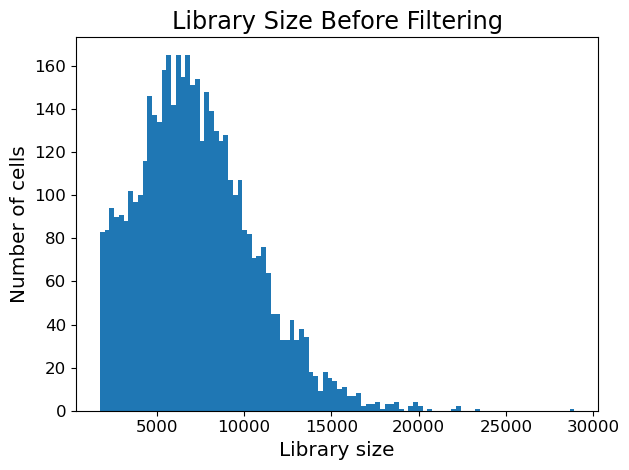

<Axes: title={'center': 'Library Size Before Filtering'}, xlabel='Library size', ylabel='Number of cells'>

In [11]:
scprep.plot.plot_library_size(data_time1, log=False, title="Library Size Before Filtering")

在细胞的主要分布区间上下选择阈值，移除显著小于平均值和显著大于平均值的细胞。你可以运行`scprep.plot.plot_library_size`并设置`cutoff=(低阈值, 高阈值)`或`percentile=(低百分位, 高百分位)`来绘制结果，其中低阈值、高阈值为具体数值，低百分位、高百分位为你选择的百分位数。

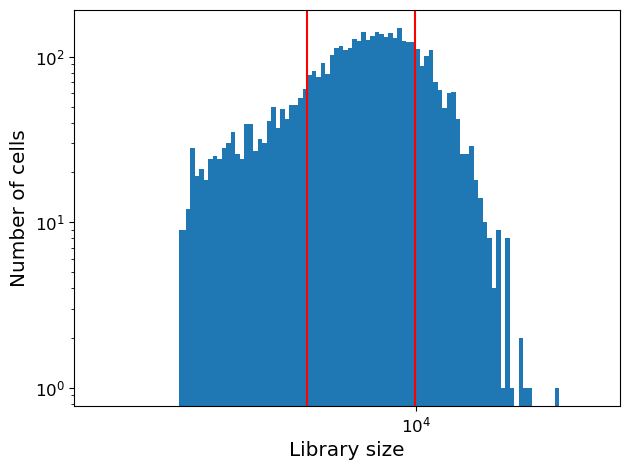

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [12]:
# =============
# Select appropriate percentiles (percentile=(low, high))
# for filtering and plot the result
scprep.plot.plot_library_size(data_time1, percentile=(20, 80))
# =============

#### 选择阈值

有几篇论文描述了选择最大和最小阈值的策略，在谷歌上快速搜索“library size threshold single cell RNA seq”即可找到。

其中大多数采用任意衡量标准，例如低于或高于文库大小平均值或中位数一定数量的标准差。我们发现，花太多时间纠结于确切的阈值效率不高，因为超过某个最小阈值后，过滤结果往往具有稳健性。

对于上述数据集，我们建议移除所有每细胞UMI数超过12,000的细胞，担心它们可能代表双细胞。我们通常还会移除所有每细胞UMI数少于1000的细胞。

### 练习1 - 按文库大小过滤细胞

你可以使用[`scprep.filter.filter_library_size()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.filter.filter_library_size)来完成此操作。

In [13]:
filtered_batches = []
for batch in [data_time1, data_time2, data_time3, data_time4, data_time5]:
    # ==================
    # fill in your chosen `percentile` values
    percentiles = (20, 80)
    batch = scprep.filter.filter_library_size(batch, percentile=percentiles)
    # ==================
    filtered_batches.append(batch)
del data_time1, data_time2, data_time3, data_time4, data_time5  # removes objects from memory

**注意：** 如果你打算使用`percentile`（百分位）过滤，需要对每个样本单独进行过滤。如果你打算使用固定数值进行过滤（例如“移除所有每细胞UMI数超过12000的细胞”），则可以对所有数据一起进行过滤。

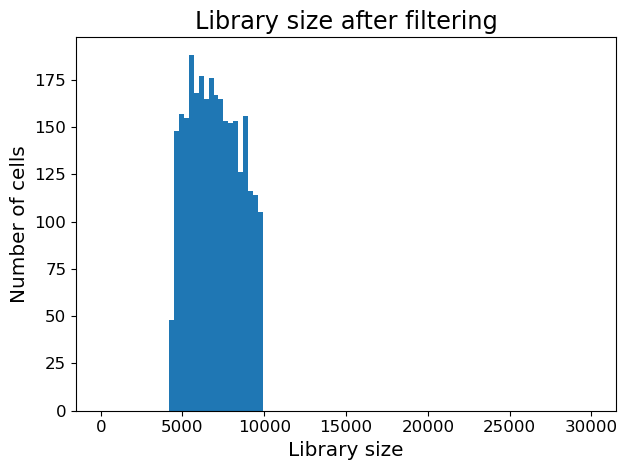

<Axes: title={'center': 'Library size after filtering'}, xlabel='Library size', ylabel='Number of cells'>

In [14]:
scprep.plot.plot_library_size(
    filtered_batches[0], log=False, range=(0, 30000), title="Library size after filtering"
)

现在文库大小的分布范围受到了更严格的限制，这将减少文库大小差异带来的影响（即便经过标准化处理，这种差异仍可能对你的结果产生干扰）。

### 2.4. 合并所有数据集并创建一个代表每个样本时间点的向量

既然我们已经通过文库大小过滤了数据集，就可以将它们合并成一个单一矩阵。你可以使用[`scprep.utils.combine_batches()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.utils.combine_batches)来完成此操作。

In [15]:
data, sample_labels = scprep.utils.combine_batches(
    filtered_batches, ["Day 00-03", "Day 06-09", "Day 12-15", "Day 18-21", "Day 24-27"]
)
del filtered_batches  # removes objects from memory
data.shape

(18691, 33694)

合并批次后，我们得到了约25,000个细胞和33,700个基因。下面我们快速查看一下这个合并后的矩阵。

In [16]:
data.head()

,A1BG (ENSG00000121410),A1BG-AS1 (ENSG00000268895),A1CF (ENSG00000148584),A2M (ENSG00000175899),A2M-AS1 (ENSG00000245105),A2ML1 (ENSG00000166535),A2ML1-AS1 (ENSG00000256661),A2ML1-AS2 (ENSG00000256904),A3GALT2 (ENSG00000184389),A4GALT (ENSG00000128274),...,ZXDC (ENSG00000070476),ZYG11A (ENSG00000203995),ZYG11B (ENSG00000162378),ZYX (ENSG00000159840),ZZEF1 (ENSG00000074755),ZZZ3 (ENSG00000036549),bP-21264C1.2 (ENSG00000278932),bP-2171C21.3 (ENSG00000279501),bP-2189O9.3 (ENSG00000279579),hsa-mir-1253 (ENSG00000272920)
AAACATTGAAAGCA-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGCAGAAA-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGGAAGGC-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGCACCGGTAT-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGCACCTATTC-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


现在我们有了一个包含实验所有五个时间点数据的矩阵，以及一个向量（`sample_labels`），用于指示哪些细胞（行）来自哪个时间点。正如你所见，时间点信息也被附加到了细胞条形码上。

In [17]:
sample_labels

AAACATTGAAAGCA-1_Day 00-03    Day 00-03
AAACCGTGCAGAAA-1_Day 00-03    Day 00-03
AAACCGTGGAAGGC-1_Day 00-03    Day 00-03
AAACGCACCGGTAT-1_Day 00-03    Day 00-03
AAACGCACCTATTC-1_Day 00-03    Day 00-03
                                ...    
TTTCTACTCTTATC-1_Day 24-27    Day 24-27
TTTCTACTTGAGCT-1_Day 24-27    Day 24-27
TTTGCATGATGACC-1_Day 24-27    Day 24-27
TTTGCATGCACTCC-1_Day 24-27    Day 24-27
TTTGCATGTTCTTG-1_Day 24-27    Day 24-27
Name: sample_labels, Length: 18691, dtype: object

最后，由于Google Colab客户端并非性能最强大的客户端，我们会对该数据集进行子采样，以便你能更快地运行预处理步骤。

In [18]:
# 运行此单元格以对数据集进行子采样(样本数n=8888),如果不运行则用全样本(n=18691)运行
# 注意,接下来的内容是原文基于没有子采样的数据集,所以文本中的数字和代码中的数值会有差异,以代码运行结果为准
#data, sample_labels = scprep.select.subsample(data, sample_labels, n=8888)

In [19]:
# 子采样后数据形状
data.shape, sample_labels.shape

((18691, 33694), (18691,))

#### 批次效应
值得注意的是，我们在此处已将五项不同的实验合并为一个数据矩阵，而这种操作可能会使我们面临“批次效应”问题。批次效应指的是某一实验的两个批次之间存在的差异，这种差异可能是技术性的，也可能是生物性的。其成因可能是系统性误差（例如文库制备过程中的温度差异），也可能是研究中真正关注的生物效应（例如本案例中，每个批次的样本均来自不同的发育时间点）。

技术性或系统性批次效应的校正本身就是一个独立课题，我们将在研讨会后续内容中展开讲解。但需注意的是，每当我们合并多个实验数据时，都应检查这些数据是否存在显著差异，并将其与我们的预期进行对比。若发现差异显著且超出预期，我们有两种选择：a) 尝试通过计算方法对其进行校正或加以考虑；b) 调整分析方案，避免合并这些数据集。

### 讨论
1. 为何要移除UMI计数（或文库大小）较低的细胞？
UMI计数（或文库大小）较低的细胞很可能是空液滴。

2. 为何要移除UMI计数（或文库大小）较高的细胞？
UMI计数（或文库大小）极高的细胞，其包含两个细胞（即双细胞）的概率更高。


<a id='preprocessing'></a>
## 3. 预处理：过滤、标准化与转换
所有这些步骤均在合并后的完整数据上执行。

### 过滤
我们通过以下方式对数据进行过滤：
1. 移除死亡细胞
2. 按文库大小过滤（若在合并批次前未执行此步骤）
3. 移除在相对较少细胞中表达的基因

注: 前两项过滤是在行上进行，而第三项过滤是在列上进行。第2步已经在上面实现了，所以下文只有1,3步的实现.

### 3.1 死亡细胞移除

#### 高线粒体基因表达意味着什么？

通常，我们认为线粒体RNA检测值高的细胞，其线粒体膜已经因细胞凋亡而发生降解。这可能是由于解离、培养过程中的应激，或者实验流程中任何环节的影响所致。与文库大小过高或过低的细胞一样，我们希望从分布中移除这一长尾部分。在成功的实验中，通常有5%-10%的细胞会呈现这种凋亡特征。

#### 线粒体表达的绘图

让我们来看一下线粒体的表达情况。你可以使用[`scprep.plot.plot_gene_set_expression()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.plot.plot_gene_set_expression)函数来实现，该函数借助辅助函数[`scprep.select.get_gene_set()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.select.get_gene_set)，能便捷地通过名称获取线粒体基因列表。

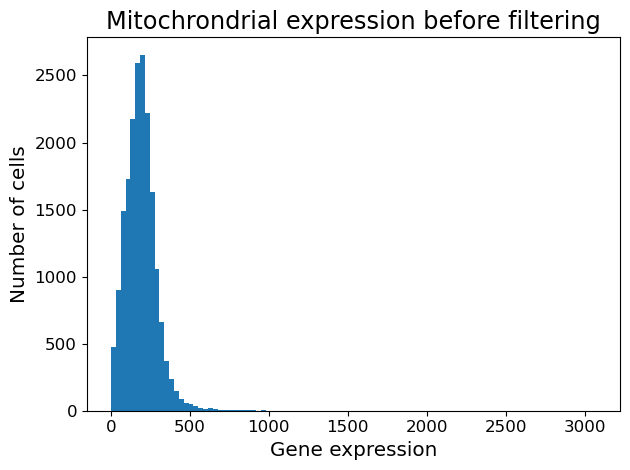

<Axes: title={'center': 'Mitochrondrial expression before filtering'}, xlabel='Gene expression', ylabel='Number of cells'>

In [20]:
# Plot all mitochondrial genes. There are 14, FYI.
scprep.plot.plot_gene_set_expression(
    data,
    starts_with="MT-",
    library_size_normalize=True,
    title="Mitochrondrial expression before filtering",
)

在这里我们可以看到，超过某个阈值后，线粒体RNA的表达量会急剧增加。我们将把这些细胞从后续分析中移除。根据上面的直方图选择一个阈值，并在新的直方图上标出你选择的值。

### 练习2 - 根据线粒体表达过滤死亡细胞

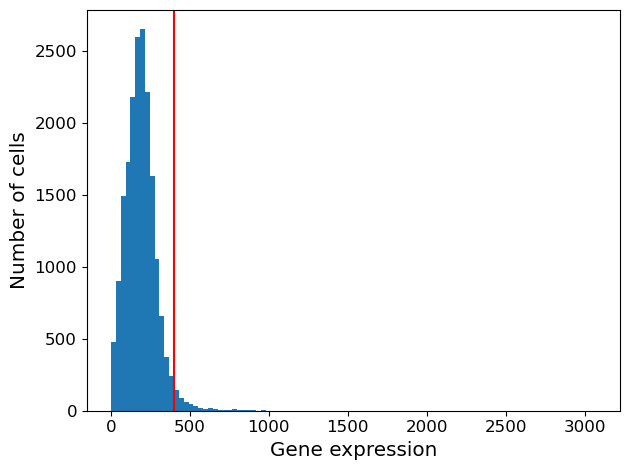

<Axes: xlabel='Gene expression', ylabel='Number of cells'>

In [21]:
# ================
# choose a cutoff at which to plot a red line such that you
# remove cells with aberrant mitochondrial expression
scprep.plot.plot_gene_set_expression(
    data, starts_with="MT-", library_size_normalize=True, cutoff=400
)
# ================

现在我们可以移除这些细胞.

In [22]:
# ================
# Fill in your chosen cutoff value
cutoff = 400
# ================
data_filt, sample_labels = scprep.filter.filter_gene_set_expression(
    data,
    sample_labels,
    starts_with="MT-",
    cutoff=cutoff,
    keep_cells="below",
    library_size_normalize=True,
)
data_filt.shape

(18203, 33694)

移除线粒体表达量处于前10%的细胞后，我们还剩下9000个细胞。让我们再看一下这个直方图。

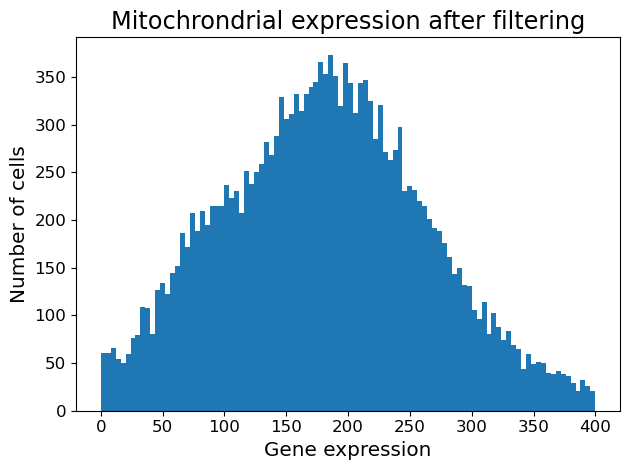

<Axes: title={'center': 'Mitochrondrial expression after filtering'}, xlabel='Gene expression', ylabel='Number of cells'>

In [23]:
scprep.plot.plot_gene_set_expression(
    data_filt,
    starts_with="MT-",
    library_size_normalize=True,
    title="Mitochrondrial expression after filtering",
)

好多了！我们得到了一个无长尾的紧凑分布，这表明所有细胞的线粒体表达都处于相对正常的水平。

### 3.2 - 过滤低表达基因

#### 为何要移除低表达基因？

从单细胞中捕获RNA是一个充满噪声的过程。第一轮逆转录是在细胞裂解物存在的情况下进行的，这导致只能捕获细胞中10%-40%的mRNA分子，从而产生一种称为“脱落”（dropout）的现象——即某些低表达基因在其实际表达的细胞中未能被检测到[[1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5561556/#CR13)、[2](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5561556/#CR44)、[3](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5561556/#CR64)、[4](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5561556/#CR65)]。因此，有些基因的表达量极低（或根本不表达），以至于我们没有足够的该基因观测数据来对其表达情况做出任何推断。

低表达基因可能仅由少量mRNA组成，它们可能不会出现在特定数据集中，还有一些可能仅存在于少数细胞中。由于我们对这些基因缺乏足够的信息，在预处理阶段会将低表达基因从基因表达矩阵中移除。通常，如果一个基因仅在极少数细胞中被检测到，就会被移除。

在这里，我们可以看到在EB数据集中，有许多基因仅在极少数细胞中被检测到。

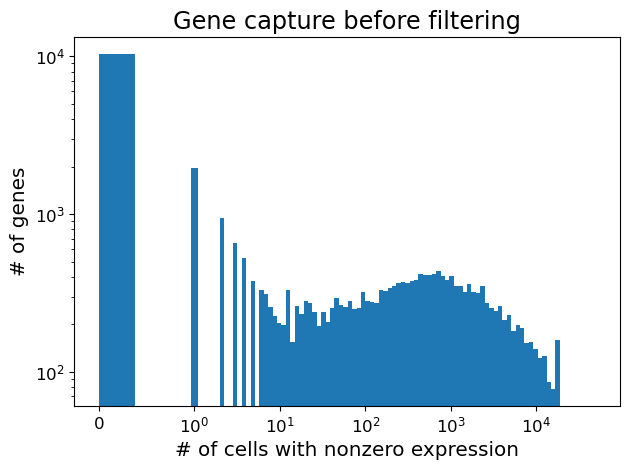

<Axes: title={'center': 'Gene capture before filtering'}, xlabel='# of cells with nonzero expression', ylabel='# of genes'>

In [24]:
scprep.plot.histogram(
    scprep.measure.gene_capture_count(data_filt),
    log=True,
    title="Gene capture before filtering",
    xlabel="# of cells with nonzero expression",
    ylabel="# of genes",
)

我们再次看到，右侧呈现出相对清晰的分布（在许多细胞中观测到的基因），同时右侧还有一条明显的长尾（稀有基因）。你会选择在哪里设置 cutoff值呢？

### 练习3 - 过滤稀有基因

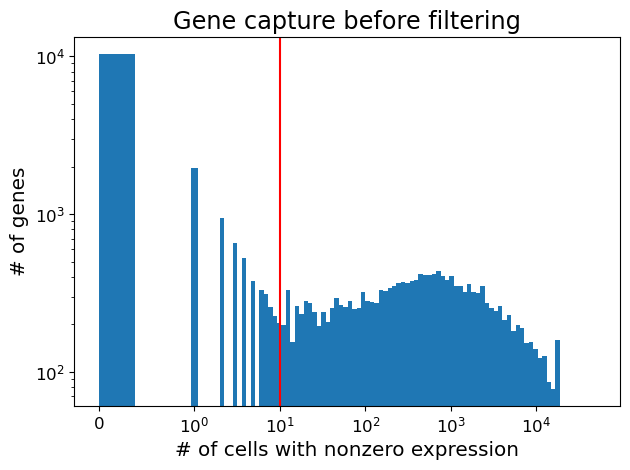

<Axes: title={'center': 'Gene capture before filtering'}, xlabel='# of cells with nonzero expression', ylabel='# of genes'>

In [25]:
# ================
# choose a cutoff
scprep.plot.histogram(
    scprep.measure.gene_capture_count(data_filt),
    cutoff=10,
    log=True,
    title="Gene capture before filtering",
    xlabel="# of cells with nonzero expression",
    ylabel="# of genes",
)
# ================

接下来移除这些基因.

In [26]:
# ================
# choose a cutoff
cutoff = 10
data_filt = scprep.filter.filter_rare_genes(data_filt, min_cells=cutoff)
# ================

为了更清楚地展示结果，我们可以再次绘制上述直方图。如你所见，稀有基因已全部被移除。

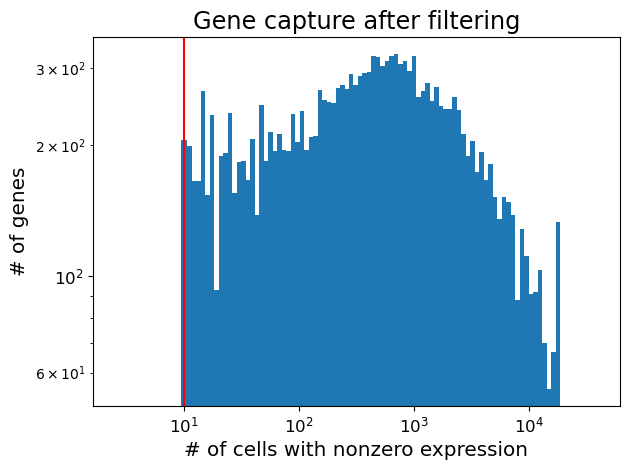

<Axes: title={'center': 'Gene capture after filtering'}, xlabel='# of cells with nonzero expression', ylabel='# of genes'>

In [27]:
scprep.plot.histogram(
    scprep.measure.gene_capture_count(data_filt),
    cutoff=cutoff,
    log=True,
    title="Gene capture after filtering",
    xlabel="# of cells with nonzero expression",
    ylabel="# of genes",
)

data_filt.shape

过滤后，我们已经移除了数千个基因。这将是我们最后的最后一个过滤步骤，不过你始终可以根据具体情况临时过滤掉异常表达的基因。目前来看，我们已将数据集从最初的10,000×33,000大幅缩减。而且这还没算上在合并时间点之前，我们根据文库大小移除的那些细胞呢！

### 3.3 - 标准化

正如你在过滤过程中所看到的，不同细胞之间的文库大小差异可能非常显著。我们曾针对过滤前的一个时间点对这种差异进行了可视化处理，现在让我们对过滤后的整个数据集进行可视化展示。

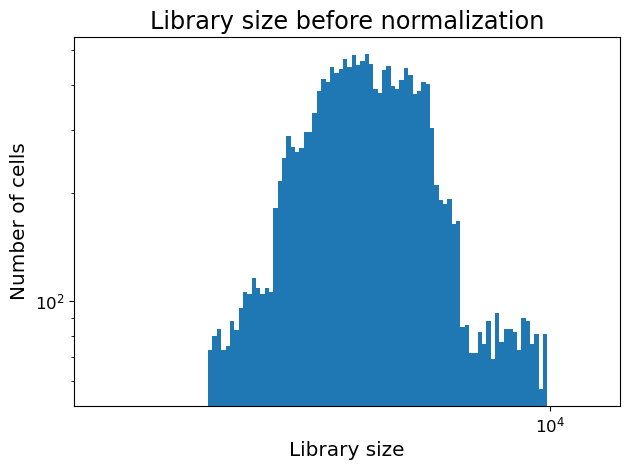

<Axes: title={'center': 'Library size before normalization'}, xlabel='Library size', ylabel='Number of cells'>

In [28]:
scprep.plot.plot_library_size(data_filt, title="Library size before normalization")

为校正文库大小的差异，我们会将每个细胞的计数除以其自身的文库大小，然后再按一个固定值重新缩放，这个固定值有时是文库大小的中位数。在`scprep`库中，默认设置是将每个细胞的计数重新缩放至10,000，以便不同数据集间的数值具有可比性。

在Python中，可通过预处理方法[`scprep.normalize.library_size_normalize()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.normalize.library_size_normalize)实现这一操作。

In [29]:
scprep.normalize.library_size_normalize

<function scprep.normalize.library_size_normalize(data, rescale=10000, return_library_size=False)>

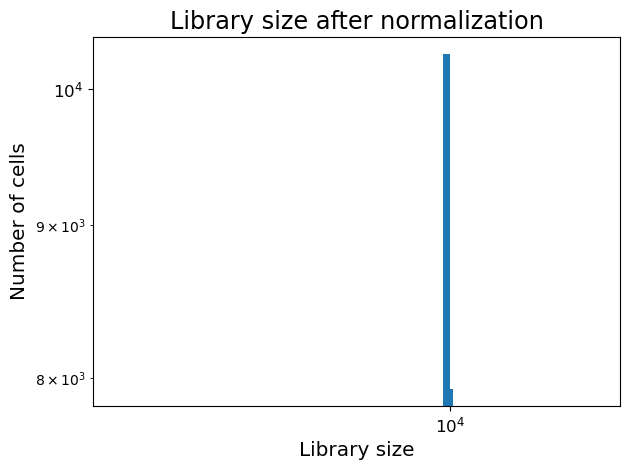

<Axes: title={'center': 'Library size after normalization'}, xlabel='Library size', ylabel='Number of cells'>

In [30]:
# 原文只是展示这个函数的参数,没有调用,以下调用并展示标准化后的结果,下文使用的data_norm也未定义,故使用这个变量名
data_norm = scprep.normalize.library_size_normalize(data_filt)
scprep.plot.plot_library_size(data_norm, title="Library size after normalization")

#### 创建`metadata`数据框（DataFrame）
现在你会发现，我们有两个元数据对象：`sample_labels`（样本标签）和`library_size`（文库大小）。我们可以按以下方式将它们整合到一个数据框中，以便后续操作更便捷。

In [31]:
# 原文没有展示连接的逻辑, 而且library_size应该是个标量也不是用来整合成dataframe的,所以这里手动实现
metadata = pd.concat([data_norm,sample_labels], axis=1)
metadata

,A1BG (ENSG00000121410),A1BG-AS1 (ENSG00000268895),A2M (ENSG00000175899),A2M-AS1 (ENSG00000245105),A2ML1 (ENSG00000166535),A4GALT (ENSG00000128274),AAAS (ENSG00000094914),AACS (ENSG00000081760),AADAT (ENSG00000109576),AAED1 (ENSG00000158122),...,ZWINT (ENSG00000122952),ZXDA (ENSG00000198205),ZXDB (ENSG00000198455),ZXDC (ENSG00000070476),ZYG11A (ENSG00000203995),ZYG11B (ENSG00000162378),ZYX (ENSG00000159840),ZZEF1 (ENSG00000074755),ZZZ3 (ENSG00000036549),sample_labels
AAACATTGAAAGCA-1_Day 00-03,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,3.485535,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Day 00-03
AAACCGTGCAGAAA-1_Day 00-03,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Day 00-03
AAACCGTGGAAGGC-1_Day 00-03,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,1.291322,0.000000,0.0,...,1.291322,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Day 00-03
AAACGCACCGGTAT-1_Day 00-03,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Day 00-03
AAACGCACCTATTC-1_Day 00-03,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,1.237011,0.0,0.0,0.0,0.0,0.0,1.237011,0.0,0.0,Day 00-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCTACTCTTATC-1_Day 24-27,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,4.076641,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Day 24-27
TTTCTACTTGAGCT-1_Day 24-27,4.291845,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Day 24-27
TTTGCATGATGACC-1_Day 24-27,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Day 24-27
TTTGCATGCACTCC-1_Day 24-27,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,5.094244,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Day 24-27


### 3.4 - 基因计数转换
在单细胞RNA测序（scRNA-seq）分析中，我们常会发现某些基因的表达量比其他基因高出好几个数量级。下面我们来查看每个基因的平均表达量。

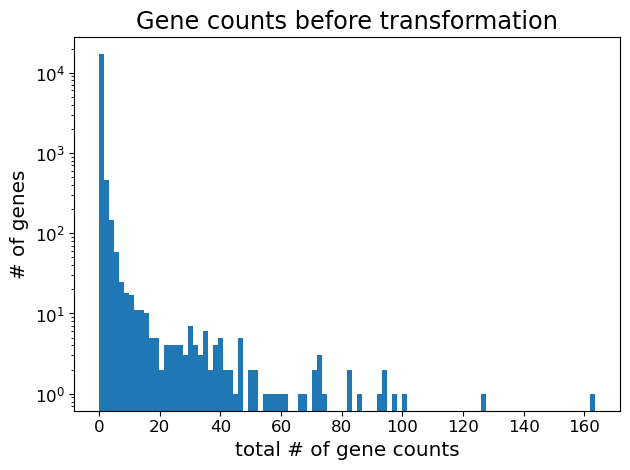

<Axes: title={'center': 'Gene counts before transformation'}, xlabel='total # of gene counts', ylabel='# of genes'>

In [32]:
scprep.plot.histogram(
    data_norm.mean(axis=0),
    log="y",
    title="Gene counts before transformation",
    xlabel="total # of gene counts",
    ylabel="# of genes",
)

### 3.5 - 筛选高可变基因
许多分析流程都会包含筛选高可变基因的步骤。基因变异性定义为特定基因均值下，实际方差相对于预期方差的比值，也称为“标准化方差”。也就是说，均值高的基因仅因其数值规模，自然会有更高的方差；而我们关注的是那些变异程度超出随机概率预期的基因。

你可以使用[`scprep.plot.plot_gene_variability()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.plot.plot_gene_variability)函数绘制标准化方差图。

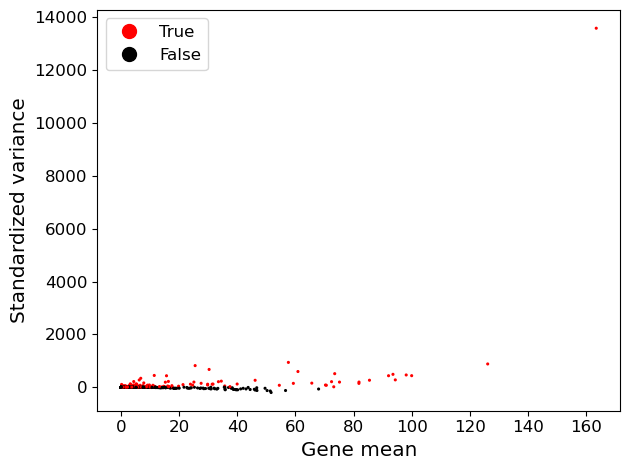

<Axes: xlabel='Gene mean', ylabel='Standardized variance'>

In [33]:
# 原文使用了一个从未定义的变量data_sqrt, 不能运行成功, 这里使用data_norm
# scprep.plot.plot_gene_variability(data_sqrt, percentile=90)
scprep.plot.plot_gene_variability(data_norm, percentile=90)


如果想要筛选高可变基因，可以使用函数[`scprep.select.highly_variable_genes()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.select.highly_variable_genes).

In [34]:
# data_hvg = scprep.select.highly_variable_genes(data_sqrt, percentile=90)
data_hvg = scprep.select.highly_variable_genes(data_norm, percentile=90)

In [35]:
data_hvg.shape

(18203, 1779)

不出所料，现在我们仅剩下1800个基因。这个规模缩减后的数据集十分有用，例如可用于降维和聚类分析——这些内容我们将在研讨会后续部分讲解。

最后，让我们保存这份预处理后的数据（我们会保留所有基因，而非仅保留高可变基因），以备后续使用。

In [36]:
data_hvg.to_pickle("../data/embryoid_body_data.pickle.gz")
metadata.to_pickle("../data/embryoid_body_metadata.pickle.gz")

In [ ]:
# 原文没提示要安装以下库, 这里手动安装, 当然, 你也可以在命令行中安装
# !pip install scanpy
# !pip install phate
# !pip3 install igraph
# !pip3 install leidenalg

# 以下一段代码基本无法运行, 而且没有任何文字说明, 不明白这一段的意义. 
# 对原代码做了较大修改, 不保证是否符合原文意思

In [ ]:
import scanpy as sc
import pandas as pd
import os
import numpy as np

# 使用以下自定义函数处理数据并保存为h5ad文件
# 假设data_filt和metadata已定义，这里添加数据验证和处理
def prepare_and_save_adata(data_filt, metadata, download_path, filename="ebdata_v1.h5ad"):
    # 1. 验证并处理data_filt（确保是二维数组）
    if not isinstance(data_filt, (np.ndarray, pd.DataFrame)):
        raise ValueError("data_filt必须是numpy数组或pandas DataFrame")
    if len(data_filt.shape) != 2:
        raise ValueError("data_filt必须是二维数组 (细胞数 x 基因数)")
    
    # 2. 验证并处理metadata（确保是DataFrame且索引匹配）
    if not isinstance(metadata, pd.DataFrame):
        raise ValueError("metadata必须是pandas DataFrame")
    if len(metadata) != data_filt.shape[0]:
        raise ValueError("metadata的行数必须与data_filt的细胞数匹配")
    
    # 3. 处理metadata中的SparseArray类型列（关键修复）
    for col in metadata.columns:
        # 检测稀疏类型
        if isinstance(metadata[col].dtype, pd.SparseDtype):
            # 转换为普通数组（兼容不同pandas版本）
            metadata[col] = metadata[col].to_numpy().ravel()
        # 处理可能的其他不兼容类型（如列表）
        elif metadata[col].dtype == 'object' and any(isinstance(x, (list, dict)) for x in metadata[col]):
            # 转换为字符串存储
            metadata[col] = metadata[col].astype(str)
    
    # 4. 创建AnnData对象
    adata = sc.AnnData(X=data_filt, obs=metadata)
    
    # 5. 处理保存路径
    # 确保下载目录存在
    os.makedirs(download_path, exist_ok=True)
    # 正确拼接路径（自动处理不同系统的斜杠）
    save_path = os.path.join(download_path, filename)
    
    # 6. 尝试保存并处理可能的错误
    try:
        adata.write_h5ad(save_path)
        print(f"成功保存到: {save_path}")
        return adata
    except Exception as e:
        print(f"保存失败: {str(e)}")
        # 进一步排查obs中的问题列
        problematic_cols = []
        for col in adata.obs.columns:
            try:
                # 测试单独保存该列
                pd.DataFrame(adata.obs[col]).to_hdf('temp_test.h5', key='test')
            except:
                problematic_cols.append(col)
        if problematic_cols:
            print(f"检测到可能的问题列: {problematic_cols}")
            print("尝试移除这些列后再次保存...")
            adata.obs = adata.obs.drop(columns=problematic_cols)
            adata.write_h5ad(save_path)
            print(f"已移除问题列并保存到: {save_path}")
        return adata

# 使用示例（请替换为你的实际数据）
# 假设以下变量已存在：
# data_filt: 过滤后的表达矩阵（二维数组）
# metadata: 细胞的元数据（DataFrame）
# download_path: 保存路径（如 "./data/"）

# 调用函数
# adata = prepare_and_save_adata(data_filt, metadata, download_path)


In [ ]:
adata = prepare_and_save_adata(data_filt, metadata, download_path)

In [ ]:
sc.pp.normalize_total(adata)

In [ ]:
adata.X = np.sqrt(adata.X)

In [ ]:
sc.external.tl.phate(adata)

In [ ]:
adata.write_h5ad(download_path + "ebdata_normalized.h5ad")

In [ ]:
# 前面根本没有这个文件, 无法加载. 而且这个变量data与上下文无任何关系, 直接跳过
# data = np.load(download_path + "eb_velocity_v5.npz")

In [ ]:
adata

In [ ]:
adata_raw = adata

In [ ]:
sc.pp.calculate_qc_metrics(adata_raw, inplace=True)

In [ ]:
sc.pp.normalize_total(adata_raw)

In [ ]:
sc.pp.log1p(adata_raw)

In [ ]:
sc.pp.neighbors(adata_raw)

In [ ]:
sc.tl.umap(adata_raw)

In [ ]:
sc.tl.tsne(adata_raw)

In [ ]:
adata_raw.write_h5ad(download_path + "ebdata.h5ad", compression="gzip")

In [ ]:
adata_raw

In [ ]:
sc.pl.scatter(adata, basis="phate", color="sample_labels")

In [ ]:
sc.pl.scatter(adata_raw, basis="umap", color="sample_labels")


In [ ]:
sc.pl.scatter(adata_raw, basis="tsne", color="sample_labels")

In [ ]:
adata = adata_raw

In [ ]:
sc.pl.scatter(adata, basis="phate", color="total_counts")

In [ ]:
sc.tl.leiden(adata, resolution=0.5)

In [ ]:
# 1. 首先确保已计算降维结果（如 UMAP，若未计算需先运行）
if "X_umap" not in adata.obsm:
    sc.pp.neighbors(adata)  # 计算邻接图（聚类和降维的基础）
    sc.tl.umap(adata)      # 计算 UMAP 降维

# 2. 绘制 UMAP 图并按 Leiden 聚类着色（最常用）
sc.pl.umap(
    adata,
    color="leiden",  # 按聚类结果着色
    title="Leiden Clustering (resolution=0.5)",  # 图表标题
    legend_loc="on data",  # 图例直接标在图上（适合聚类少的情况）
    # legend_loc="right margin",  # 图例放在右侧（适合聚类多的情况）
    frameon=False  # 去除边框
)

# 3. 其他可选绘图方式
# 绘制 t-SNE 图（若已计算 "X_tsne"）
if "X_tsne" in adata.obsm:
    sc.pl.tsne(adata, color="leiden", title="Leiden Clustering on t-SNE")

# 绘制 PCA 图（若已计算 "X_pca"）
sc.pl.pca(adata, color="leiden", title="Leiden Clustering on PCA")

# 4. 进阶：调整颜色和样式
sc.pl.umap(
    adata,
    color="leiden",
    palette="tab20",  # 使用自定义颜色板（适合多聚类）
    size=50,  # 点的大小
    alpha=0.8,  # 点的透明度
    save="_leiden_clusters.png"  # 保存图片（自动添加 .png 后缀）
)

In [ ]:
del adata.uns["leiden_colors"]

In [ ]:
sc.pl.scatter(adata, basis="phate", color="leiden")

In [ ]:
adata.var["gene_name"] = [s.split()[0] for s in adata.var.index]

In [ ]:
adata.var["gene_id"] = [s.split()[1] for s in adata.var.index]

In [ ]:
adata.var["gene_name_id"] = adata.var.index

In [ ]:
adata.write_h5ad(download_path + "ebdata.h5ad", compression="gzip")

In [ ]:
adata.var.gene_name[adata.var.gene_name.str.startswith("POU5")]

In [ ]:
gene_map = {
    "ESC": ["NANOG", "POU5F1"],
    "PS": ["EOMES", "MIXL1", "CER1", "SATB1", "T"],
    "Pre-NE": ["POU5F1", "OTX2"],
    "ME": ["T"],
    "EN": ["ARID3A"],
    "NE-2": ["GBX2", "OLIG3", "HOXD1"],
    "NE-1": ["GBX2", "ZIC2", "ZIC5"],
    "Lateral Plate ME": ["TBX5", "HOXD9", "MYC"],
    "Hemangioblast": ["TAL1", "HOXB4", "SOX17", "CD34", "PECAM1"],
    "Cardiac-2": ["NKX2-5", "LEF1", "MYC"],
    "EN-2": ["GATA3", "SATB1", "SOX15"],
    "EN-1": ["FOXA2", "SOX17"],
    "NE/NC": ["HOXA2", "HOXB1"],
    "NE-1 2": ["ZIC2", "ZIC5", "GLI3", "LHX2", "LHX5", "PAX6", "SIX3", "SIX6"],
    "Epicardial Precursors": ["WT1"],
    "Smooth Muschle Precursors": ["TBX18", "SIX2", "TBX15", "PDGFRA"],
    "Cardiac Precursors-1": ["GATA5"],
    "Cardiac Precursors-2": ["GATA6"],
    "Cardiac Precursors-3": ["TNNT2"],
    "Posterior EN": ["CDX2", "ASCL2", "KLF5", "NKX2-1"],
    "NC": ["PAX3", "FOXD3", "SOX9", "SOX10"],
    "NP": ["NES", "MAP2"],
    "Neuronal Subtypes-1": ["KLF7", "ISL1", "DLX1", "ONECUT1", "ONECUT2"],
    "Neuronal Subtypes-2": ["OLIG1", "NPAS1", "LHX2", "NR2F1"],
    "Neuronal Subtypes-3": ["OLIG1", "NPAS1", "DMRT3", "LMX1A"],
    "Neuronal Subtypes-4": ["NKX2-8", "EN2", "SOX1"],
    "Neuronal Subtypes-5": ["PAX6", "ZBTB16"],
}

In [ ]:
adata

In [ ]:
adata.uns["gene_map"] = gene_map

In [ ]:
adata.uns["gene_map"]

In [ ]:
full_gene_list = []
for k, v in gene_map.items():
    full_gene_list.extend(v)

In [ ]:
adata_sub = adata[:, adata.var.gene_name.isin(full_gene_list)]

In [ ]:
adata_sub